# Data-X Project: Electricity Price Prediction
## Feature Modeling Group: Machine Learning Optimization Pipeline

Description of Notebook

Retail electricity prices across different regions will have varying dependencies on all kinds of other signals in the energy marketplace. This notebook is an "pipeline" that integrates any available regional data (as well as national data) into an automated feature and machine learning model selection routine. The process is highly iterative and computationally intensive. However, the prediction of long term retail electricity prices is not time sensitive. It is not particularly desirable, but not necessarily awful for this notebook to run over the course of hours or days. 

The eventual output is visualizations of different models' average performances across ranges of feature combinations and hyperparameter combinations. The best-performing-on-average combination or combinations of [model X feature grouping X hyperparameter set] will be used (on their own or averaged) to make future predicitions of energy price. Other high performing combinations will combine to form tolerance bands for the prediction.

Team Members: Aaron Drew, Arbaaz Shakir, JOhn Stuart, Adam Yankelevits, Eric Yehl

## Import Libraries

Import open source packages and files defining custom functions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rnd
import gspread
from oauth2client.service_account import ServiceAccountCredentials

## Data Collection

Source data streams for a particular region (probably manual).

## Data Aggregation

Stitch many data streams into a Google Sheet and create a pandas dataframe by importing from Sheets API.

Columns: Features

Rows: Timestamps

In [2]:
# Use credentials to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)

# Read the spreadsheet and convert to a Pandas dataframe
sheet = client.open("FINAL DATA").sheet1
data = pd.DataFrame(sheet.get_all_records(empty2zero=True)) # will be a column name alphabetized dataframe
data.astype('float64')
data.head()

,AllFuelsGen,AvgMaxTemp,AvgRelHum,AvgRetailPrice,AvgTemp,BiofuelsCons,BiomassCap,BiomassCons,CA_GDP,CoalCap,...,TotIndNatGasCons,TotIndOtherNatGasCons,TotNatGasCons,TotRetailElecSales,TotTransNatGasCons,TotalElecCap,WasteCons,WindCap,WindCons,WoodCons
0,16618.89,60.48,51.45,6.75,52.22,23.74,1143.00,230.53,1638.07,429.0,...,782.14,686.54,2677.00,21744.32,77.62,55364.00,30.81,1534.00,4.02,175.98
1,14380.39,57.29,71.37,6.87,50.04,20.08,1142.67,203.26,1637.15,429.0,...,726.85,640.03,2309.46,18305.56,66.89,55540.83,27.21,1534.83,4.46,155.97
2,15848.63,67.10,77.43,7.01,56.12,21.55,1142.33,220.01,1636.24,429.0,...,761.36,664.92,2246.63,21351.41,64.86,55717.67,30.32,1535.67,5.50,168.14
3,15841.02,65.57,72.80,7.02,54.87,18.71,1142.00,212.80,1635.32,429.0,...,714.66,622.05,1807.17,18855.60,51.93,55894.50,30.12,1536.50,7.08,163.97
4,16874.50,81.29,72.58,7.17,66.45,19.58,1141.67,210.86,1634.40,429.0,...,671.51,576.53,1522.38,19862.26,43.47,56071.33,29.83,1537.33,6.56,161.46


In [11]:
data = data[0:180]

In [12]:
mean_std_normed_data = (data-data.mean())/data.std()
min_max_normed_data = (data-data.min())/(data.max()-data.min())

## Data Cleaning

Fill in missing values using interpolation, or condense high resolution data.

## Data Transformation

Convert data signals to smooth moving averages, removing seasonal oscillations.

Track average, seasonal peaks, and seasonal troughs.

Normalize all signals (maybe). 

Find best fit polynomial for seasonal deviation over the course of one year.

## Exploratory Data Analysis with Correlation Matrices

### Pearson correlation matrix "heat map" for colinearity between all features.

In [5]:
# Close figures in the background
plt.close("all")

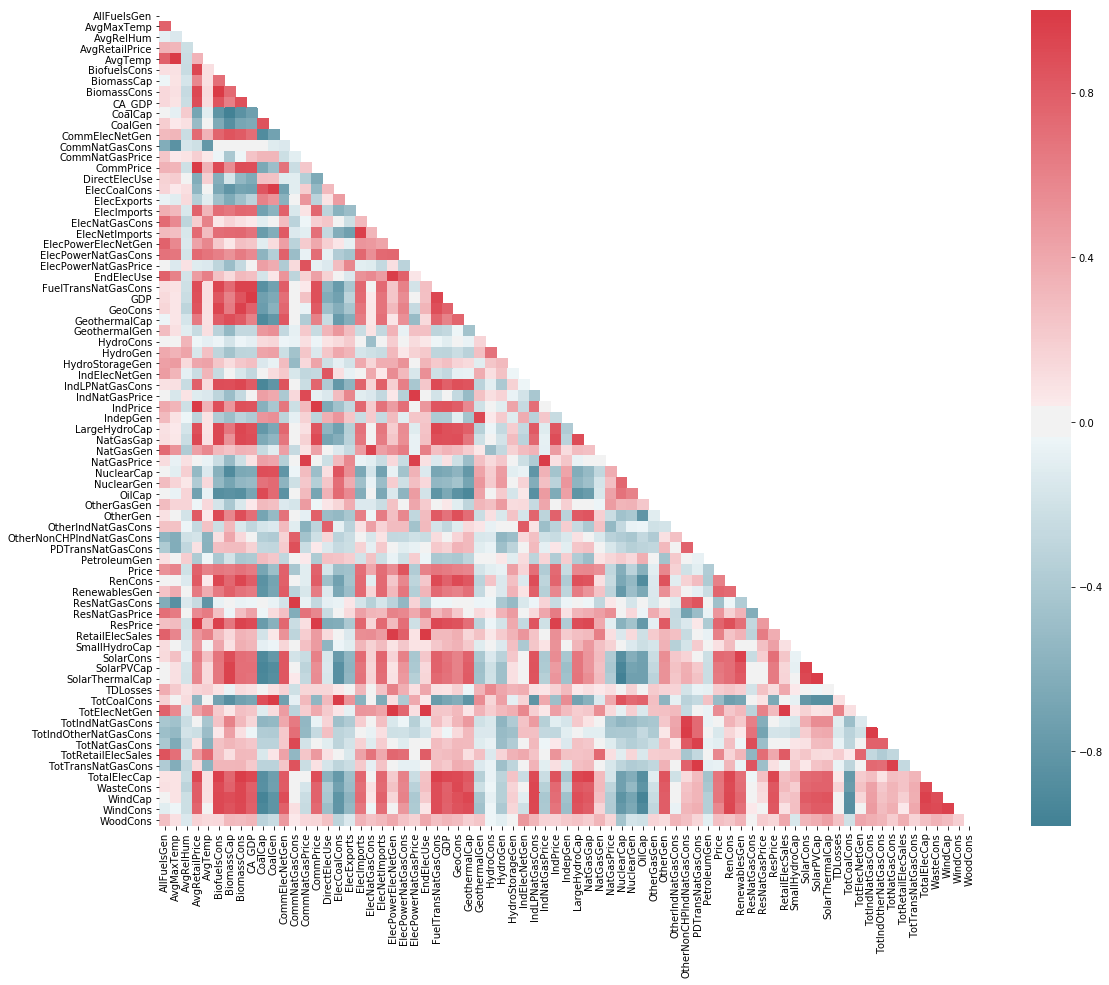

In [13]:
# Compute the correlation matrix
feature_corr = mean_std_normed_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
reg_heatmap, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.round(feature_corr,2), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=0, annot=False, annot_kws={"size": 7}, cbar_kws={"shrink":1})
reg_heatmap

### Time displaced correlations of all features with price

Displace (advance) feature signals by n months. This will line up past signals with future prices. Truncate n months at the end of feature signals and n months at the beginning of price signals.

/Users/eric_yehl/anaconda3/envs/data-x/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


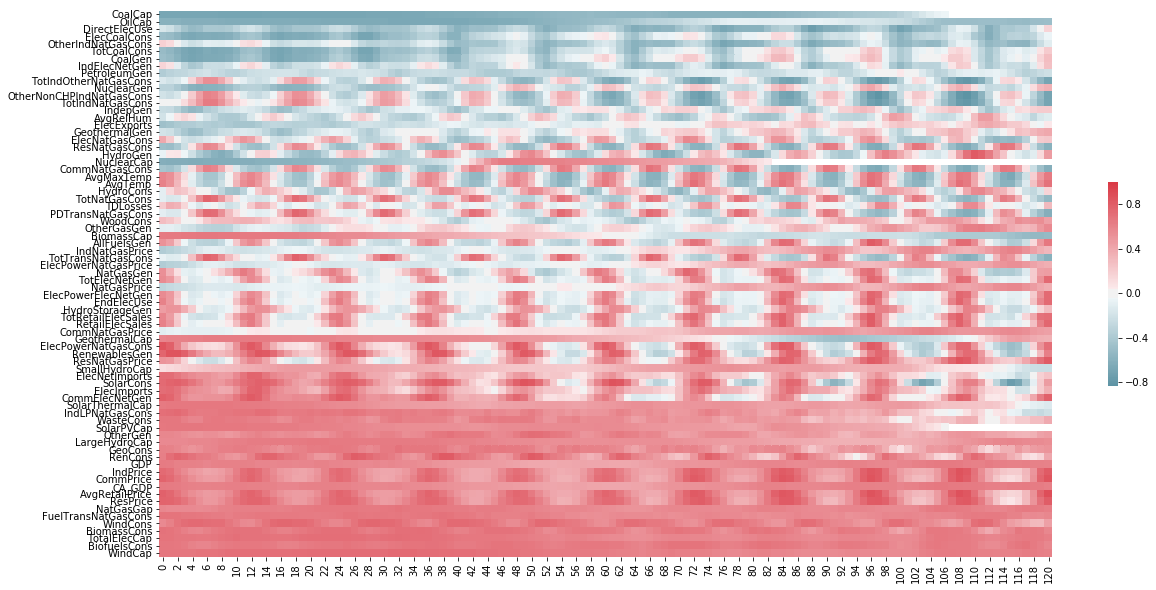

In [15]:
n = 120 # Number of months to look backward

num_cols = data.shape[1] # Number of dataframe columns

# Create an empty correlation matrix. Rows will be features and columns will be time delays.
time_corr = np.zeros((num_cols-1,n+1))
feature_names = list(data.drop('Price',axis=1))

for i in range(1,num_cols): # For every feature (price must be in 0th column)
    for j in range(n+1):    # For every month delay, from 0 up to and including n
        # Truncate beginning of price signal
        price = data['Price'][j:len(data['Price'])+1]
        # Truncate end of feature signal
        feature_name = feature_names[i-1]
        #print(feature_name)
        feature = data[feature_name][0:len(data[feature_name])-j]
        time_corr[i-1,j] = np.round(np.cov(price,feature)[0,1]/(np.std(price)*np.std(feature)),2)

# Set up the matplotlib figure
time_heatmap, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create dataframe from matrix of correlations
time_corr_df = pd.DataFrame(data=np.transpose(time_corr),columns = feature_names)
time_corr_df = time_corr_df.reindex_axis(time_corr_df.mean().sort_values().index, axis=1)

# Generate heat map
sns.heatmap(time_corr_df.transpose(), cmap=cmap, vmax=1, center=0,
            square=True, linewidths=0, annot=False, annot_kws={"size": 7}, cbar_kws={"shrink":.25})
time_heatmap

## Data Visualization

Plot features against each other in 3+ dimensions.

## Feature Construction

Create new features using derivatives (perhaps first interpolating with polynomials, then taking the derivative(s) of these instead of using finite difference), powers, time offsets, and perhaps products and quotients of these. Do this intelligently so as not to create an intractable amount of combinations.

## New Correlation Matrices

Pearson correlation matrix "heat map" for colinearity between all features (old and new).

Time displaced correlation matrix "heat map" for colinearity between all features (old and new) and electricity price at offset times.

## Create Test Matrix of Model/Feature Combinations

Pandas dataframe with:

Columns: Features, Hyperparameters, 1 column for model type, 1 column for average test results
Rows: Different combinations of the above
Data: 1's and 0's for feature inclusion, hyperparameter values, average test results

## Run Test Matrix of Model/Feature Combinations

Run many separate model trainings & performance tests for each combination below, averaging the __test__ results:

[ML algorithm X hyperparameter set X feature grouping]

Fill out pandas dataframe with average performance test results.


## Visualize Performance Matrix

Display test results graphically.

## Make Predictions